# Looking at Air BnB listings in Bristol, UK
Importing the needed packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
from textblob import TextBlob
import statsmodels.api as sm

#### Question One: Are there long-term and periodic trends for Airbnb usage in Bristol since the first listings in 2011?

In [3]:
#importing reviews dataset, which shows date of each review for each listing
reviews = pd.read_csv('./reviews.csv', parse_dates=["date"]) 
reviews.head()

,listing_id,date
0,70820,2013-10-18
1,70820,2013-10-28
2,70820,2013-11-12
3,70820,2014-05-17
4,70820,2014-06-15


Reviews contains two columns only - the listing_id and the date of the review. There are no missing values. For the sake of this analysis, I assume the review took place in the same month as the actual stay. There is no other record of stay dates.

Next I resampled reviews to calculate cummulative monthly review counts for the entire Bristol area. I considered trimming the timeseries to not include 2020 so that long-term trends pre-covid could be analyzed, but I decided to include 2020 to show how the long-term trend suddenly changes. This illustrates the uncertainty that must be accounted for in trying to extrapolate trend data into the future.

In [4]:
#setting date as the index
reviews.index = reviews['date']
#resampling to monthly count of reviews for all listings combined, and limiting
monthly_reviews = reviews.resample('M', label = 'left', loffset = '1d').count()
monthly_reviews['reviews_per_month'] = monthly_reviews.date
monthly_reviews = monthly_reviews.drop(['listing_id', 'date'], axis = 1)

Plot of monthly reviews, showing strong growth in reviews since first listing reviews in 2011. Apparent seasonality as well. 




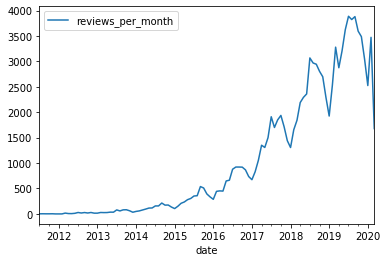

In [5]:
monthly_reviews.plot()

Although the dramatic upward trend in reviews is clearly evident, it would be nice to apply a model that will attempt to separate out the underlying long-term trend, the seasonlity, and residual variations. I chose to use the statsmodels time series analysis seasonal decomposition filter. 

I used the 'additive' model option, because the results are easier for the observer to interpret. If I were going to pursue this analysis further, I would have to compare the performance and applicability of the 'additive' vs. the 'multiplicative' models. This is really just a first attempt at getting familiar with seasonality filtering. 

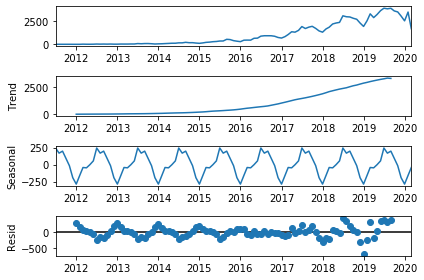

In [6]:
#trend and seasonality analysis
decomposition = sm.tsa.seasonal_decompose(monthly_reviews, model = 'additive')
#plots of trend, seasonality, and residuals for the additive seasonal decomposition model
fig = decomposition.plot()
plt.rcParams['figure.figsize'] = [12.0, 12.0]

The filter identified some seasonality, but in reality the model only fits decently in 2016. In the years before 2016, the residuals are canceling out the seasonality. In the years after 2016, the residuals are boosting the seasonality.

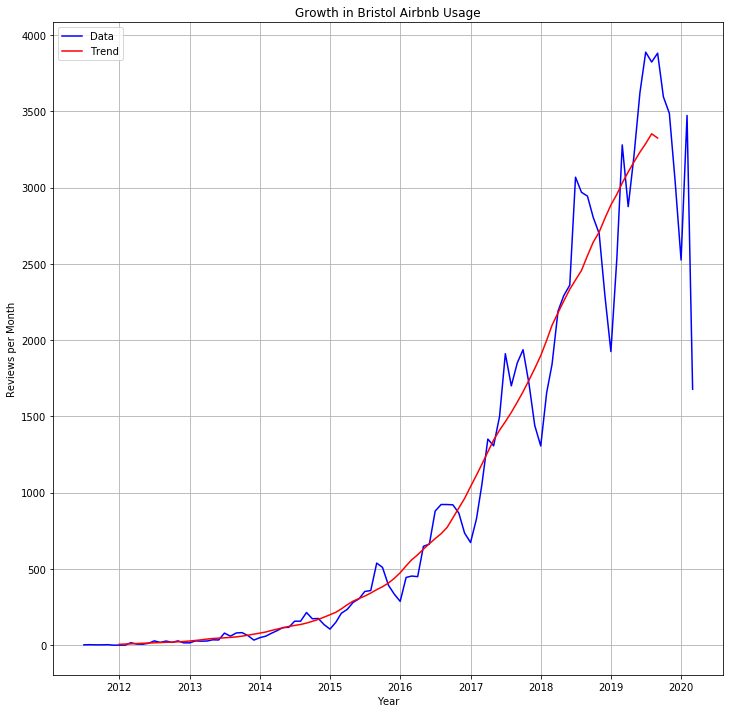

In [7]:
#plotting trend line and actual reviews per month
fig, ax = plt.subplots()
ax.grid(True)
plt.plot(monthly_reviews.index, monthly_reviews['reviews_per_month'], c='blue', label = 'Data')
plt.plot(decomposition.trend.index, decomposition.trend, c='red', label = 'Trend')
plt.xlabel('Year')
plt.ylabel('Reviews per Month')
plt.title('Growth in Bristol Airbnb Usage')
plt.legend()

#### Question One Conclusion
Since 2011, there has been a consistent uptrend in listing reviews. However, Coronavirus lock-down means that the uptrend is now broken. It will be interesting to see how long it takes for the uptrend to continue after restrictions are eased. 

There is a seasonal component to the variation in listing reviews. Due to the rapid growth in listing reviews, it is difficult to isolate the seasonal contribution to variation without applying more advanced modeling techniques.

#### Questions Two & Three: What does it take to have a frequently visited listing that remains popular long-term? Can the written comment sentiment be used to approximate the average numeric rating for listings?

In [8]:
#here's a more detailed reviews dataset that has written comments from the reviews
reviews_detail = pd.read_csv('./reviews_detail.csv', parse_dates=["date"]) 
reviews_detail.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,70820,8163487,2013-10-18,7538116,Neralee,We loved our stay with Sarah in Bristol. She w...
1,70820,8397676,2013-10-28,9601180,Terry,Sarah gave us and Laddie our dog a very warm w...
2,70820,8706695,2013-11-12,9697980,Alice,Exactly as described on the site and praised b...
3,70820,13024371,2014-05-17,2388955,Thomas,"Sarah was great. She was warm and welcoming, e..."
4,70820,14247963,2014-06-15,16317003,Dimitrije,The experience was really great at Sarah's hou...


I applied the TextBlog sentiment analysis tool to see if I could distinguish well reviewed listings from poorly reviewed listings. The reviews_detail dataset doesn't contain the numeric review scores. I will have to relate the aggregated review sentiment to the aggregated review score from the list_detail dataset.

In [9]:
#calculating sentiment polarity for each review comment, using TextBlob
sentiment = []
for row in reviews_detail.comments:
    text = str(row)
    comment = TextBlob(text)
    polarity = comment.sentiment.polarity
    sentiment.append(polarity)

#append the sentiment list to reviews_detail df
reviews_detail['sentiment'] = sentiment 

#aggregate mean review sentiment polarity for each listing_id, and drop listings with < 1 comments
listing_mean_sent = pd.concat([reviews_detail.groupby('listing_id')['sentiment'].median(), reviews_detail.groupby('listing_id')['comments'].count()], axis = 1)
listing_mean_sent = listing_mean_sent[listing_mean_sent.comments >= 1]
listing_mean_sent.comments.min()

1

Now I have the mean sentiment polarity score for each listing that had at least 1 written review comment. Polarity can range from -1 to 1, where -1 is entirely negative, 0 is neutral, and 1 is entirely positive.

In [10]:
#merging the mean listing sentiment polarity to the listing details df
#the list_detail dateset contains the average review scores for each listing
list_detail = pd.read_csv('./listings_detail.csv', parse_dates=["last_review", 'first_review'])
list_detail.index =   list_detail['id']
list_detail = list_detail.merge(listing_mean_sent, how = 'left', left_index = True, right_index = True)
print(*list_detail.columns, sep = ', ')

id, listing_url, scrape_id, last_scraped, name, summary, space, description, experiences_offered, neighborhood_overview, notes, transit, access, interaction, house_rules, thumbnail_url, medium_url, picture_url, xl_picture_url, host_id, host_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, street, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, city, state, zipcode, market, smart_location, country_code, country, latitude, longitude, is_location_exact, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, amenities, square_feet, price, weekly_price, monthly_price, security_deposit, cleaning_fee, guests_included, extra_people, minimum_nights, maximum_nights, minimum_minimum_nights, maximum_m

Next, I wanted to know how long each listing was active, so I calculated the timedelta in years between the first and last reviews. This will be used as the hue in the scatterplot below.

In [11]:
#calculating the listing age by difference between first review date and last review date
current = pd.to_datetime('2020-04-01')
list_detail.first_review
list_detail['listing_age'] = list_detail.last_review.dt.year - list_detail.first_review.dt.year
list_detail.listing_age.describe()

count    2447.000000
mean        1.574990
std         1.584108
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: listing_age, dtype: float64

The scatter plot below is intended to help visualize what it takes to have a popular listing.

Text(0, 0.5, 'Number of Reviews')

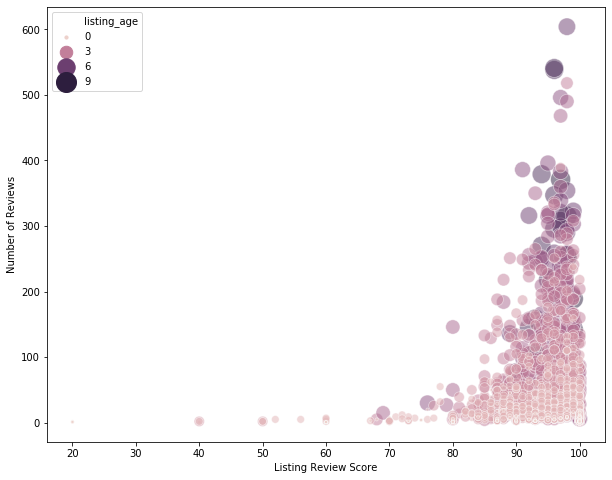

In [12]:
#scatter plot of listing score vs. number of comments
plt.figure(figsize=(10, 8))
sns.scatterplot(x = list_detail.review_scores_rating, y = list_detail.comments, hue = list_detail.listing_age, size = list_detail.listing_age, sizes = (10,400), legend = 'brief', alpha = 0.5)
plt.xlabel('Listing Review Score')
plt.ylabel('Number of Reviews')

Looking at the relationship between mean listing review score and number of reviews, it's pretty clear that listings that get poor reviews don't get many visitors, and generally don't last for many years. It also appears to take a few years to accummulate hundreds of reviews.

In [13]:
list_detail.review_scores_rating.describe()

count    2409.000000
mean       94.372769
std         7.731028
min        20.000000
25%        92.000000
50%        97.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

#### Question 2 Conclusion
Looking at the relationship between mean listing review score and number of reviews, it's pretty clear that listings that get poor reviews don't get many visitors. It's also clear that poorly reviewed listings generally don't last for many years. 

In fact, in order to even register in the 25th percentile of mean listing scores, your listing will need to garner a 92%! To be average (median), you'll need a 97%.

People seem to be pretty risk averse when it comes to choosing an Airbnb. Therefore, it would behoove anyone considering listing a place to be on their A-game before opening up to visitors.

On the other hand, staying at an Airbnb is a little more personal of an experience than buying something online. Therefore, it feels a bit more confrontational to leave a poor Airbnb review. I think that is partially why the reviews scores tend to be so high.

##### Text sentiment analysis
For the text sentiment analysis, I chose to consider a bad listing to have a review score rating below 70% in order to give the sentiment analysis the absolute worst listings to compare with the absolute best listings, which I defined as a review score rating >= 97%.

In [14]:
#comparing sentiment polarity to review scores
sentiment_accuracy = list_detail[['sentiment','review_scores_rating']].dropna(axis = 0, how = 'any')
sentiment_accuracy['score_good'] = np.where(sentiment_accuracy['review_scores_rating'] >= 70, 'Ok', 'bad')
sentiment_accuracy['score_good'].where(sentiment_accuracy['review_scores_rating'] < 97.0, other = 'great', inplace = True)
sentiment_accuracy

,sentiment,review_scores_rating,score_good
id,,,
70820,0.399479,95.0,Ok
117122,0.399926,99.0,great
146407,0.352500,90.0,Ok
176306,0.400755,94.0,Ok
307634,0.300347,91.0,Ok
...,...,...,...
42574180,0.311868,100.0,great
42600338,0.575000,100.0,great
42628756,0.306250,100.0,great


Now scores are categorized: less than 70% is bad, 70 to <97% is OK, and >= 97% is great 

Text(0, 0.5, 'Listing Median Sentiment')

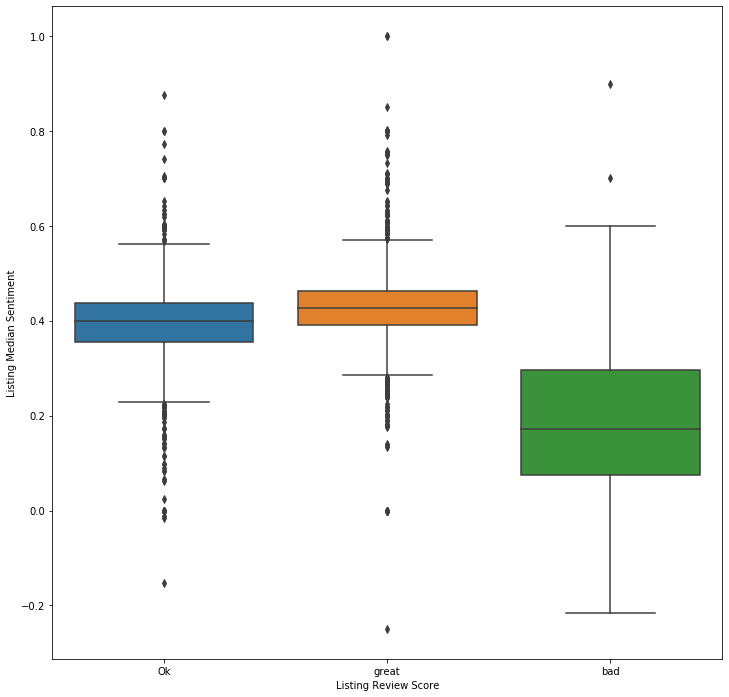

In [15]:
sentiment_accuracy = sentiment_accuracy.drop(['review_scores_rating'], axis = 1)
sentiment_accuracy_pivot = sentiment_accuracy.pivot(columns = 'score_good', values = 'sentiment')
sns.boxplot(x = sentiment_accuracy.score_good, y = sentiment_accuracy.sentiment, orient = 'v')
plt.xlabel('Listing Review Score')
plt.ylabel('Listing Median Sentiment')
#plt.savefig(fname = 'sentiment box.jpg', dpi = 200)

#### Question 3 Conclusion
The interquartile range (IQR of listing median sentiment for bad listings does not overlap with the IQR of OK and great listings. This is just a first brush at using text sentiment analysis. As it is, I could see a use for it in getting an overall picture of review scores. However, to be useful in distinguishing which score category a particular listing falls in, more work would be needed. Of course there is no guarantee that people's written comments convey the sentiment of the score they leave.

#### Question 4: What are the price distributions in each neighborhood for short-term listings?


In [16]:
#filter out listings with no 'last review'
list_detail = pd.read_csv('./listings_detail.csv', parse_dates=["last_review", 'first_review'])
list_detail_reviewed = list_detail.dropna(axis = 0, subset = ['last_review'])
list_detail_reviewed.last_review.describe()

count                    2447
unique                    573
top       2020-03-15 00:00:00
freq                      191
first     2012-03-26 00:00:00
last      2020-03-19 00:00:00
Name: last_review, dtype: object

In [17]:
#filter for listings with recent reviews. I'm interested in current pricing.
list_detail_current = list_detail_reviewed[list_detail_reviewed['last_review'] > '2018-12-31' ]
list_detail_current.last_review.describe()

count                    2085
unique                    324
top       2020-03-15 00:00:00
freq                      191
first     2019-01-01 00:00:00
last      2020-03-19 00:00:00
Name: last_review, dtype: object

In [18]:
#value counts indicate that filtering out listings with min nights > 3 will not reduce our observations very much
#I'm interested in short-term rental pricing
longstay = list_detail_current.minimum_nights_avg_ntm > 3.0
longstay.value_counts()

False    1940
True      145
Name: minimum_nights_avg_ntm, dtype: int64

In [19]:
#filter out listings requiring > 3 night minimum stay
list_detail_current = list_detail_current[list_detail_current['minimum_nights_avg_ntm'] <= 3.0 ]
list_detail_current.shape

(1940, 106)

In [20]:
#selecting neighborhoods that have at least 10 listings, and preparing to barplot
#I want representative pricing samples of neighborhoods, so I had to pick a minimum listing threshold
neighborhood = pd.concat([list_detail_current['neighbourhood_cleansed'], list_detail_current['price'].str.replace('$', '').str.replace(',', '').astype(float)], axis = 1)
neighborhood.index = neighborhood['neighbourhood_cleansed']
neighborhood['min_listings'] = neighborhood['neighbourhood_cleansed'].groupby('neighbourhood_cleansed').count() > 9
neighborhood = neighborhood[neighborhood.min_listings]
neighborhood = neighborhood.reset_index(drop = True)
neighborhood = neighborhood.drop(['min_listings'], axis = 1)
neighborhood.shape

(1928, 2)

In [21]:
#but first I want to tabulate median prices by neighborhood inorder to sort my barplot by median price
neighborhood_median_price = neighborhood.groupby('neighbourhood_cleansed')['price'].median()
neighborhood_median_price = neighborhood_median_price.sort_values(ascending = False)
neighborhood_median_price.describe()

count    32.000000
mean     49.421875
std      14.807969
min      26.000000
25%      37.250000
50%      49.000000
75%      55.750000
max      79.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution by Neighborhood')

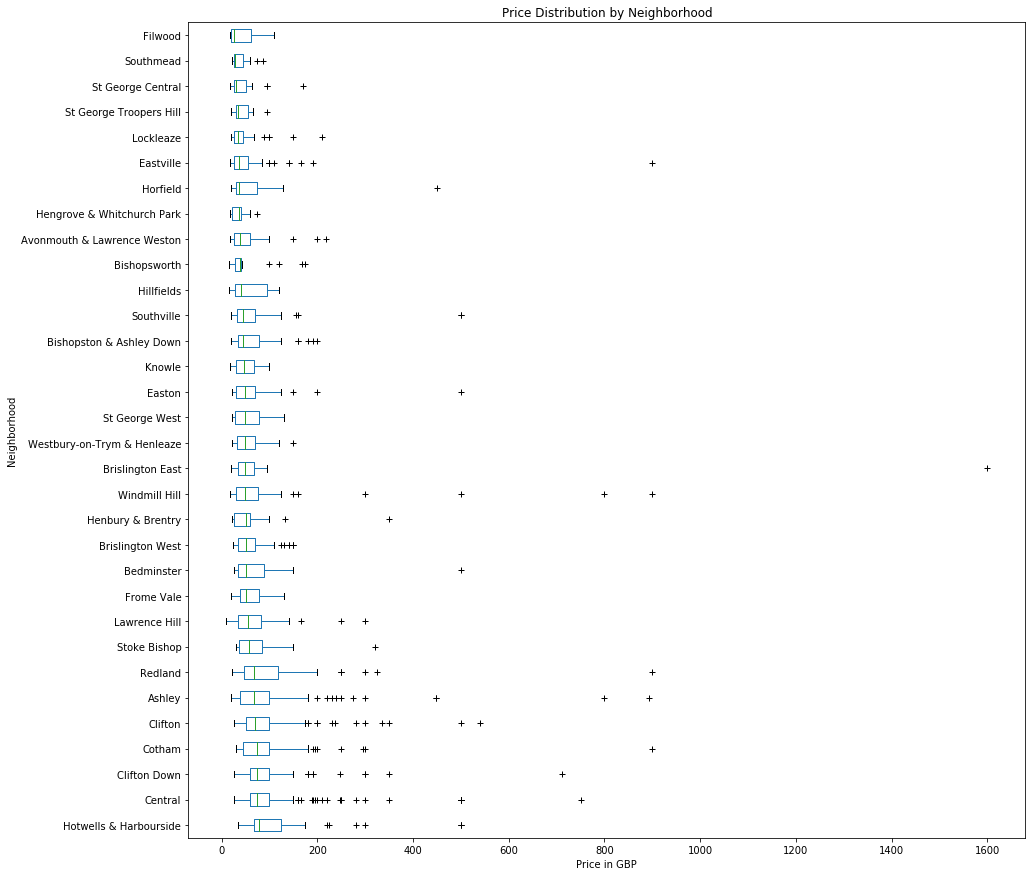

In [22]:
#boxplot of neighborhood prices, ordered by neighborhood median price
neighborhood_pivot = neighborhood.pivot(columns = 'neighbourhood_cleansed', values = 'price')
neighborhood_pivot[neighborhood_median_price.index].plot.box(vert=False, figsize=(15, 15), sym = '+')
plt.xlabel('Price in GBP')
plt.ylabel('Neighborhood')
plt.title('Price Distribution by Neighborhood')
#plt.savefig(fname = 'neighborhood_price_box.jpg', bbox_inches = 'tight', dpi = 200)

However, the price outliers are dominating the figure. Some of the prices may be errors, like prices that are meant for weekly or monthly rentals. Some places may be event or wedding venues. I decided to filter out the outliers.

Text(0.5, 1.0, 'Price Distribution by Neighborhood')

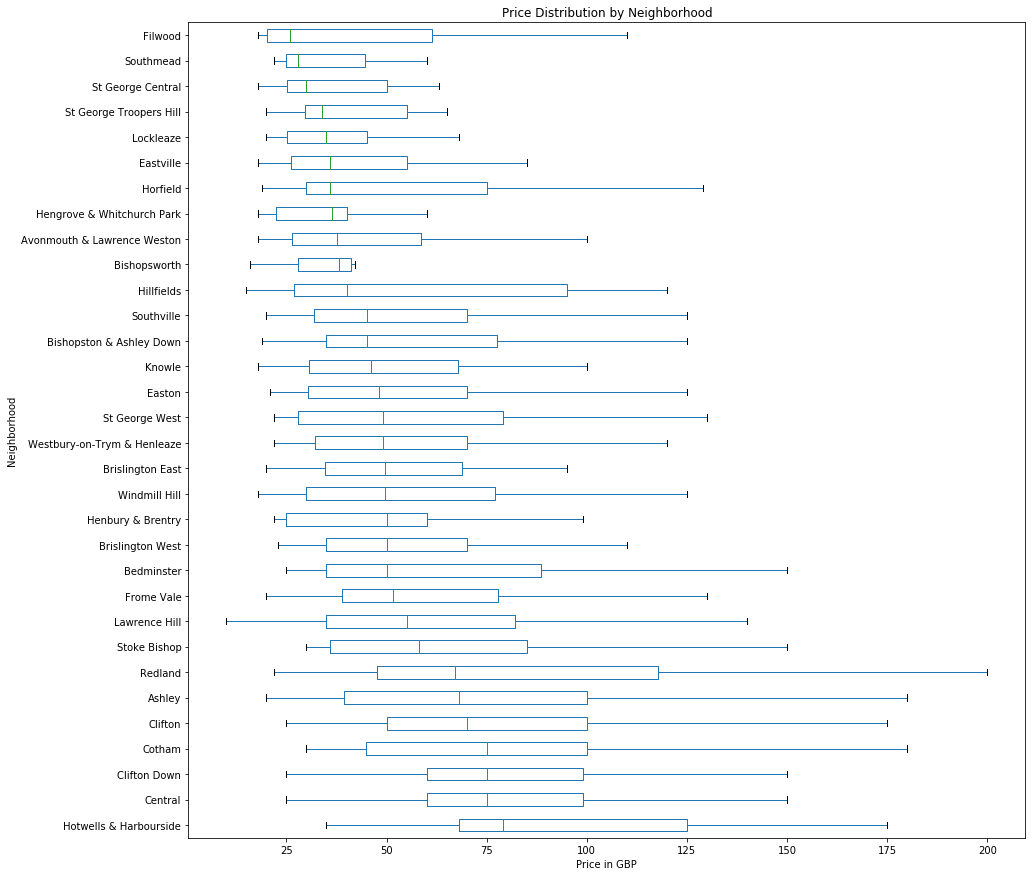

In [23]:
neighborhood_pivot[neighborhood_median_price.index].plot.box(vert=False, figsize=(15, 15), sym = '')
plt.xlabel('Price in GBP')
plt.ylabel('Neighborhood')
plt.title('Price Distribution by Neighborhood')

#### Question 4 Conclusion
This information is useful for local government planning purposes, or potentially useful for an individual looking to list with Airbnb. Clearly there are differences between neighborhood pricing, but it isn't clear how to price your listing until you compare with similar listings. However, if there aren't any similar listings in your neighborhood, but are in other neighborhoods, you could use this figure to convert the listing price to your neighborhood's relative value.